### About this Notebook 
This notebook uses Convolutional Neural Network to recognize hand-written digits. 

### Author 
This notebook was written by Mohammed Alhamid

### Objective 
Creating fully-dense Convolutional Neural Net using Keras to recognize hand-written digits provided by MNIST database. 

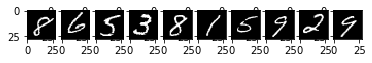

In [16]:
from IPython.display import Image 
Image("images/digits.png")

### Main libraries used 

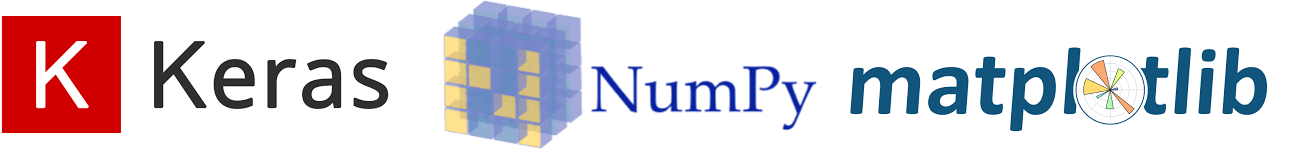

In [18]:
Image("images/library.png")

In [19]:
# Importing MNIST library from Keras
from keras.datasets import mnist
# Importing Matplotlib for visualization 
from matplotlib import pyplot
import matplotlib.pyplot as plt
# Importing Numpy library 
import numpy as np
import keras 

%matplotlib inline

Using TensorFlow backend.


### Loading the dataset

In [20]:
def load_dataset():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    return X_train, y_train, X_test, y_test

In [21]:
X_train, y_train, X_test, y_test = load_dataset()

In [22]:
#Explore the content of the dataset 
print('The number of images in the training dataset=', X_train.shape[0])
print('The number of images in the test dataset', X_test.shape[0])

The number of images in the training dataset= 60000
The number of images in the test dataset 10000


In [23]:
#The shape of images
X_train.shape

(60000, 28, 28)

In [24]:
#The shape of labels
y_train.shape

(60000,)

### Visualize some example from the dataset

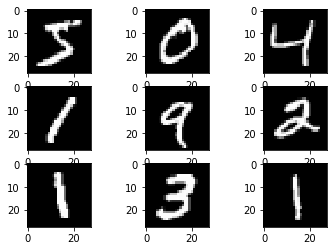

In [25]:
# Let us visualize 12 examples: 
for i in range(9):
    # set the subplot
    pyplot.subplot(330 + 1 + i)
    # plot image pixesles
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    
# Display the image
pyplot.show()

<function matplotlib.pyplot.show(*args, **kw)>

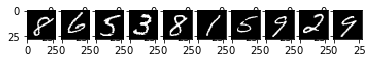

In [26]:
#Display last images
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(X_train[X_train.shape[0]-1-i], cmap="gray")
plt.show

In [27]:
# Explore the contents of the target labels 
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

# Preprocessing Training data

In [28]:
# Record the number of unique values 
print('Number of unique values', len(np.unique(y_train)))
print(np.unique(y_train))

Number of unique values 10
[0 1 2 3 4 5 6 7 8 9]


In [29]:
def process_images(X_train, X_test):
    img_x, img_y = X_train.shape[1], X_train.shape[2]
    # Reshaping the images
    X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 1)
    X_test =  X_test.reshape(X_test.shape[0], img_x, img_y, 1)
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    X_train /= 255
    X_test /= 255
    input_shape = (img_x, img_y, 1)
    return X_train, X_test, input_shape

In [30]:
X_train, X_test, input_shape = process_images(X_train, X_test)

In [31]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (60000, 28, 28, 1)
Shape of X_test (10000, 28, 28, 1)
Shape of y_train (60000,)
Shape of y_test (10000,)


# Preprocessing the labels 

In [32]:
# The number of classes is equal to 10, which represents the unique values of the vestor y_train and y_test
num_classes = 10

In [33]:
# We need first to one-hot encode the labels, this will speed up the training
y_train = keras.utils.to_categorical(y_train, num_classes)

In [34]:
#Similar encoding for the testing data
y_test = keras.utils.to_categorical(y_test, num_classes)

In [35]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [36]:
# Displaying the shape of the training label vector 
y_train.shape

(60000, 10)

In [37]:
# Displaying the shape of the testing label vector 
y_test.shape

(10000, 10)

# Building the CNN model

In [38]:
# To facilitate the building of the CNN models in different architecture, we will define the following function
#Parameters:
# batch_size: the size of the batch 
# epochs: number of epochs 
# input_shape: The input shape of the images
# w_size: The size of the feature detector (kernel window)
# p_size: The size of the pooling matrix
# n_c_layer: The number of convolutional layers
# n_d_layer: The number of dense layers 
# transfer_actfun: the transfer function for the hidden layers
# output_actfun: the output activation function
# dropout : An array that has the number of dropout layer and percentage 
# batch_nor: Boolean True/False
def build_model(batch_size, epochs, input_shape, w_size, p_size, n_c_layer, n_d_layer ,transfer_actfun, output_actfun, dropout, batch_nor): 
    # First step is creating the Neural Network model 
    model = Sequential()
    # Adding the convolution layer with 32 nuerons and 5 x 5 feature detector (size of the kernel window)
    for _ in range(n_c_layer):
        model.add(Conv2D(32, kernel_size=(w_size, w_size),
                     activation=transfer_actfun,
                     input_shape=input_shape))
    if batch_nor: 
        # Adding batch normalization
        model.add(BatchNormalization())
    #Adding the pool layer to choose the best features in size of 2x2 matrix 
    model.add(MaxPooling2D(pool_size=(p_size, p_size)))
    #Adding dropout layer if given in the parameters
    for i in range(len(dropout)): 
        model.add(Dropout(dropout[i]))
    #Next, we need to flatten the dimensions since we only have 10 classificiation outputs 
    model.add(Flatten())
    #Adding some dense layers if required: 
    for _ in range(n_d_layer): 
        model.add(Dense(128, activation='relu'))
    #Adding the output layer with softmax to produce the required output probabilities
    model.add(Dense(num_classes, activation=output_actfun))
    return model

In [39]:
# This function will be used to plot the history of the model training
def display_history(history): 
    # plotting the model accuracy and model learning lost
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()

    return fig

In [43]:
import keras
from keras.models import Sequential
# We need tom import few libaries from keras.layers to build up the CNN models 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [41]:
#Defining the model parameters 
batch_size = 128
epochs = 5

In [44]:
model = build_model(batch_size, epochs, input_shape, 5, 2, 2, 1,'sigmoid' ,'softmax', [0.25], True)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [45]:
# Compiling the model 
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy'.split())

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               409728    
__________

In [49]:
%%time
#Training the model 
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 79s - loss: 0.4760 - acc: 0.8609 - val_loss: 0.2417 - val_acc: 0.9293
Epoch 2/5
 - 85s - loss: 0.2487 - acc: 0.9254 - val_loss: 0.1759 - val_acc: 0.9472
Epoch 3/5
 - 84s - loss: 0.1933 - acc: 0.9423 - val_loss: 0.1450 - val_acc: 0.9573
Epoch 4/5
 - 84s - loss: 0.1589 - acc: 0.9529 - val_loss: 0.1187 - val_acc: 0.9637
Epoch 5/5
 - 84s - loss: 0.1373 - acc: 0.9593 - val_loss: 0.1064 - val_acc: 0.9667
CPU times: user 27min 5s, sys: 1h 21min 20s, total: 1h 48min 26s
Wall time: 6min 55s


In [50]:
# Get the evaluation of the testing dataset 
results = model.evaluate(X_test,y_test)

10000/10000 [==============================] - 6s 608us/step


In [52]:
print('Lost =', results[0] ,'  Accuracy =', results[1])

Lost = 0.10637391077354551   Accuracy = 0.9667
